# GUI - FACIAL RECOGNITION SYSTEM

### Initial Imports

In [57]:
import tkinter as tk
from tkinter import filedialog
from tkinter import messagebox
from PIL import Image, ImageTk
import cv2
import os
import time

### Setting Background Image

In [58]:
# Function to set the background image
def set_background_image(event=None):
    # Get the current window size
    window_width = window.winfo_width()
    window_height = window.winfo_height()

    # Load the image and resize it to fit the window
    bg_image = Image.open("bgimg.jpg")  # Replace with your image file
    bg_image = bg_image.resize((window_width, window_height), Image.LANCZOS)
    bg_image = ImageTk.PhotoImage(bg_image)

    bg_label.configure(image=bg_image)
    bg_label.image = bg_image  # Maintain a reference to the image object

### GENERATE DATASET BUTTON - DATASET WINDOW OPEN

In [93]:
# Function to generate dataset
def generate_dataset():
    generate_window = tk.Toplevel(window)
    generate_window.title("Generate Dataset")
    generate_window.geometry("600x400")  # Set the dimensions of the new window

    # Create UI elements for the "Generate" page 
    name_frame = tk.Frame(generate_window)
    name_frame.pack(padx=10, pady=10)

    entry_name = tk.Entry(name_frame, width=30, font=("Helvetica", 14))
    entry_name.grid(row=0, column=1, padx=5, pady=5)

    label_name = tk.Label(name_frame, text="Name:", font=("Helvetica", 14))
    label_name.grid(row=0, column=0, padx=5, pady=5)
    
    num_images_frame = tk.Frame(generate_window)
    num_images_frame.pack(padx=10, pady=10)

    entry_num_images = tk.Entry(num_images_frame, width=20, font=("Helvetica", 14))  # Set the width to the same value as entry_name
    entry_num_images.grid(row=0, column=1, padx=5, pady=5)

    label_num_images = tk.Label(num_images_frame, text="Number of Images:", font=("Helvetica", 14))
    label_num_images.grid(row=0, column=0, padx=5, pady=5)
    
    button_frame = tk.Frame(generate_window)
    button_frame.pack(padx=10, pady=10)

    capture_button = tk.Button(button_frame, text="Capture Images", font=("Helvetica", 14), bg="green", fg="white", command=lambda: capture_images(entry_name.get(), entry_num_images.get()))
    capture_button.grid(row=1, column=0, columnspan=2, padx=5, pady=10)



## Capturing Image - Collecting Datasets

In [94]:
# Function of using OpenCV
def capture_images_opencv(person_name, num_images):
    num_images = int(num_images)  # Convert the value to an integer
    print(f"Person's Name: {person_name}, Number of Images: {num_images}")

    # Set the face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Set the directory for the dataset
    dataset_path = 'dataset/'

    # Set the path for the person's dataset
    person_path = os.path.join(dataset_path, person_name)

    # Create the directory if it doesn't exist
    if not os.path.exists(person_path):
        os.makedirs(person_path)

    # Initialize the camera
    cap = cv2.VideoCapture(0)

    image_count = 0

    while image_count < num_images:
        ret, frame = cap.read()

        # Convert the frame to grayscale for face detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

        for (x, y, w, h) in faces:
            # Draw a rectangle around the face
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

            # Save the captured face
            face_img = gray[y:y+h, x:x+w]

            # Preprocess the image
            resized_face = cv2.resize(face_img, (224, 224))  # Adjust the size based on your model's input size
            normalized_face = resized_face / 255.0

            # Save the preprocessed image
            img_name = f"img{image_count+1}.jpg"
            img_path = os.path.join(person_path, img_name)
            cv2.imwrite(img_path, (normalized_face * 255).astype("uint8"))

            image_count += 1

            # Display the captured image for a short time
            cv2.imshow('Captured Face', face_img)
            cv2.waitKey(500)  # Adjust the time in milliseconds (1000 = 1 second)

        # Display the frame
        cv2.imshow('Capture Face', frame)

        # Break the loop when 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the camera
    cap.release()

    # Destroy all OpenCV windows
    cv2.destroyAllWindows()



# Function to capture images ---- Upon Clicking the BUTTON
def capture_images(person_name, num_images):
    capture_images_opencv(person_name, num_images)
    messagebox.showinfo("Dataset Generation", f"{num_images} images captured")

### TRAIN MODEL BUTTON - TRAINING WINDOW OPEN

In [141]:
# Define a global variable for training_window
training_window = None

# Function to train model
def train_model():
    global training_window  # Declare training_window as a global variable
    training_window = tk.Toplevel(window)
    training_window.title("Training Options")
    training_window.geometry("600x400")

    # Create a button for one-hot encoding
    one_hot_button = tk.Button(training_window, text="One-Hot Encoding", font=("Helvetica", 16), bg="green", fg="white", command=perform_one_hot_encoding)
    one_hot_button.pack(pady=20)
    

    # Create a button for CNN model training
    train_cnn_button = tk.Button(training_window, text="Train CNN Model", font=("Helvetica", 16), bg="#FFA500", fg="black", command=train_cnn_model)
    train_cnn_button.pack(pady=20)



## One-Hot Encoding &
## Data Splitting - Training and Testing

In [167]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split


# Set the directory for the dataset
dataset_path = 'dataset/'

# Get the list of persons (subdirectories)
persons = os.listdir(dataset_path)

# Create label mapping for each person
label_mapping = {person: idx for idx, person in enumerate(persons)}

# Initialize the list to store data and labels
data = []

# Loop over each person's folder
for person in persons:
    person_directory = os.path.join(dataset_path, person)

    # Get the label for the person
    label = [0] * len(persons)
    label[label_mapping[person]] = 1

    # Loop over each image in the person's folder
    for img_name in os.listdir(person_directory):
        img_path = os.path.join(person_directory, img_name)

        # Read the image 
        img = cv2.imread(img_path)

        # preprocessing
        resized_img = cv2.resize(img, (224, 224))
        normalized_img = resized_img / 255.0

        # Append the preprocessed image and label to the list
        data.append([img, label])

# Convert the list to a NumPy array
data = np.array(data)

# Shuffle the data
np.random.shuffle(data)

# Print the shape of the data
print("Shape of data:", data.shape)

# Save the data to a file (if needed)
np.save('data.npy', data)


print("Label Mapping:")
for person, label in label_mapping.items():
    print(f"{person}: {label}")


print("One-Hot Encoded Labels:")
for person, label in label_mapping.items():
    one_hot_encoded = [0] * len(label_mapping)
    one_hot_encoded[label] = 1
    print(f"{person}: {one_hot_encoded}")



# Assuming 'data' contains both images and labels
X = np.array([item[0] for item in data])
y = np.array([item[1] for item in data])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Shape of data: (600, 2)
Label Mapping:
Ajay: 0
Ananya: 1
Isha: 2
One-Hot Encoded Labels:
Ajay: [1, 0, 0]
Ananya: [0, 1, 0]
Isha: [0, 0, 1]
X_train shape: (480, 224, 224, 3)
X_test shape: (120, 224, 224, 3)
y_train shape: (480, 3)
y_test shape: (120, 3)


C:\Users\DELL\AppData\Local\Temp\ipykernel_24284\3932030360.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [157]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tkinter import messagebox 


def print_to_message_box(message):
    messagebox.showinfo("Information", message)  # Display message in a messagebox


# Function to perform one-hot encoding ---------- 

def perform_one_hot_encoding():
    # Set the directory for the dataset
    dataset_path = 'dataset/'

    # Get the list of persons (subdirectories)
    persons = os.listdir(dataset_path)

    # Create label mapping for each person
    label_mapping = {person: idx for idx, person in enumerate(persons)}

    # Initialize the list to store data and labels
    data = []

    # Loop over each person's folder
    for person in persons:
        person_directory = os.path.join(dataset_path, person)

        # Get the label for the person
        label = [0] * len(persons)
        label[label_mapping[person]] = 1

        # Loop over each image in the person's folder
        for img_name in os.listdir(person_directory):
            img_path = os.path.join(person_directory, img_name)

            # Read the image 
            img = cv2.imread(img_path)

            # Preprocessing
            resized_img = cv2.resize(img, (224, 224))
            normalized_img = resized_img / 255.0

            # Append the preprocessed image and label to the list
            data.append([img, label])

    # Convert the list to a NumPy array
    data = np.array(data)

    # Shuffle the data
    np.random.shuffle(data)
    
    # ...

    
    message = f"Shape of data: {data.shape}"
    print_to_message_box(message)

    # Save the data to a file (if needed)
    np.save('data.npy', data)

    
    label_mapping_str = "\nLabel Mapping:\n"
    for person, label in label_mapping.items():
        label_mapping_str += f"{person}: {label}\n"
    print_to_message_box(label_mapping_str)


    
    one_hot_encoded_str = "\nOne-Hot Encoded Labels:\n"
    for person, label in label_mapping.items():
        one_hot_encoded = [0] * len(label_mapping)
        one_hot_encoded[label] = 1
        one_hot_encoded_str += f"{person}: {one_hot_encoded}\n"
    print_to_message_box(one_hot_encoded_str)    

    # Assuming 'data' contains both images and labels
    X = np.array([item[0] for item in data])
    y = np.array([item[1] for item in data])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    
    training_info = "\nTraining Information:\n"
    training_info += "X_train shape: " + str(X_train.shape) + "\n"
    training_info += "X_test shape: " + str(X_test.shape) + "\n"
    training_info += "y_train shape: " + str(y_train.shape) + "\n"
    training_info += "y_test shape: " + str(y_test.shape) + "\n"
    print_to_message_box(training_info)    

    
    global training_window
    training_window.destroy()  # Close the training options window
    messagebox.showinfo("One-Hot Encoding", "One-hot encoding completed")

## CNN Model

In [174]:
import os

def count_subfolders(dataset_path):
    if not os.path.exists(dataset_path):
        return 0

    subfolders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
    return len(subfolders)


In [177]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from sklearn.metrics import classification_report, confusion_matrix

# # Define the CNN model
# model = Sequential()

# # Default parameters
# num_conv_layers = 1  # Number of convolutional layers
# num_filters = 32  # Number of filters for the first convolutional layer
# dropout_rate = 0.5  # Dropout rate
# num_output_neurons = 5  # Number of output neurons / number of classes
# num_fc_neurons = 128  # Number of neurons in the fully connected layer
# num_epochs = 2

# # Get the number of subfolders in the dataset directory
# dataset_path = 'dataset/'
# num_output_neurons = count_subfolders(dataset_path)

# # print("Number of Output Neurons:", num_output_neurons)

# model.add(Conv2D(num_filters, (3, 3), activation='relu', input_shape=(224, 224, 3)))
# model.add(MaxPooling2D((2, 2)))

# for _ in range(num_conv_layers - 1):  # Add extra convolutional layers based on user input
#     num_filters *= 2  # Double the number of filters with each layer
#     model.add(Conv2D(num_filters, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))

# model.add(Flatten())
# model.add(Dense(num_fc_neurons, activation='relu'))
# model.add(Dropout(dropout_rate))
# model.add(Dense(num_output_neurons, activation='softmax'))




Number of Output Neurons: 3


In [ ]:

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test))


In [170]:
# # Evaluate the model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
# # Make predictions on the test set
# y_pred = model.predict(X_test)

4/4 [==============================] - 1s 136ms/step - loss: 2.2946 - accuracy: 0.9750
Test Loss: 2.2945752143859863, Test Accuracy: 0.9750000238418579


4/4 [==============================] - 1s 171ms/step
Sample 1: True Label = 2, Predicted Label = 2
Sample 2: True Label = 1, Predicted Label = 1
Sample 3: True Label = 2, Predicted Label = 2
Sample 4: True Label = 1, Predicted Label = 1
Sample 5: True Label = 0, Predicted Label = 0
Sample 6: True Label = 1, Predicted Label = 1
Sample 7: True Label = 0, Predicted Label = 0
Sample 8: True Label = 0, Predicted Label = 0
Sample 9: True Label = 2, Predicted Label = 2
Sample 10: True Label = 2, Predicted Label = 2


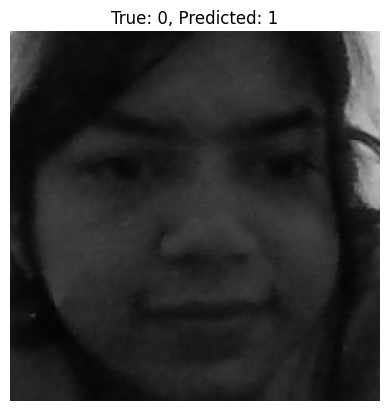

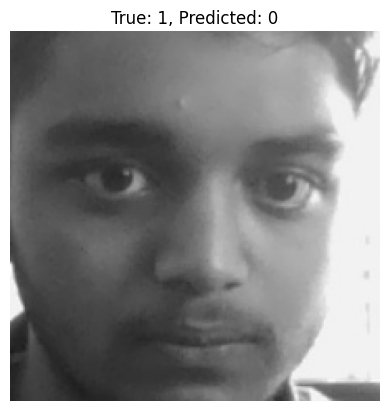

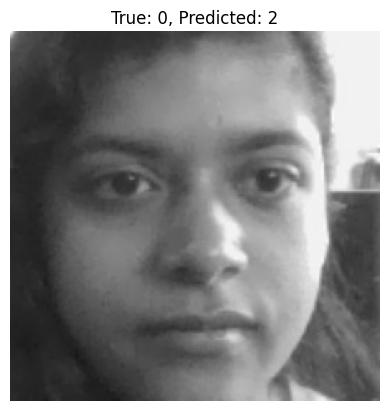

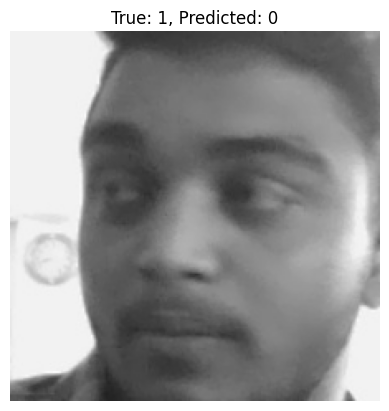

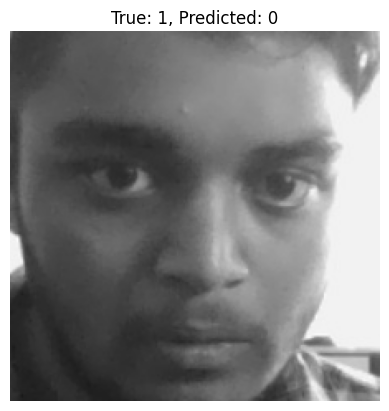

In [173]:
# import matplotlib.pyplot as plt
# import random
# from sklearn.metrics import classification_report, confusion_matrix

# # Function to convert one-hot encoded labels to class labels
# def one_hot_to_label(one_hot):
#     if len(one_hot.shape) > 1:
#         return np.argmax(one_hot, axis=1)
#     else:
#         return int(one_hot[0])  # Extract the single value from the array

# # Function to display random images from the test set with true and predicted labels
# def visualize_predictions(X_test, y_true, y_pred):
#     num_samples_to_display = 5
#     random_indices = random.sample(range(len(X_test)), num_samples_to_display)

#     for idx in random_indices:
#         # Display the image
#         plt.imshow(X_test[idx])
#         plt.title(f"True: {one_hot_to_label(y_true[idx])}, Predicted: {y_pred[idx]}")
#         plt.axis('off')
#         plt.show()

# # Make predictions on the test set
# y_pred = model.predict(X_test)

# # Convert one-hot encoded true labels to class labels
# y_true_classes = np.argmax(y_test, axis=1)

# # Convert one-hot encoded predictions to class labels
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Print true and predicted labels for a few samples
# for i in range(10):  # Adjust the range based on the number of samples you want to inspect
#     print(f"Sample {i + 1}: True Label = {y_true_classes[i]}, Predicted Label = {y_pred_classes[i]}")

# # Visualize predictions
# visualize_predictions(X_test, y_test, y_pred_classes)





In [188]:
# Function to train CNN model
def train_cnn_model():
 

    # Default parameters for the CNN model
    num_conv_layers = 1  # Number of convolutional layers
    num_filters = 32  # Number of filters for the first convolutional layer
    dropout_rate = 0.5  # Dropout rate
    num_output_neurons = 4  # Number of output neurons (adjust based on the number of classes)
    num_fc_neurons = 128  # Number of neurons in the fully connected layer
    num_epochs = 1
    
    
    # Get the number of subfolders in the dataset directory
    dataset_path = 'dataset/'
    num_output_neurons = count_subfolders(dataset_path)

    # print("Number of Output Neurons:", num_output_neurons)
    
    # User Defined Parameters



    # Define the CNN model
    model = Sequential()

    model.add(Conv2D(num_filters, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))

    for _ in range(num_conv_layers - 1):  # Add extra convolutional layers based on user input
        num_filters *= 2  # Double the number of filters with each layer
        model.add(Conv2D(num_filters, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(num_fc_neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_output_neurons, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test))

    global training_window
    training_window.destroy()  # Close the training options window
    messagebox.showinfo("Model Training", "Model training completed")


In [189]:
# # Function to train CNN model
# def train_cnn_model():
#     # Add code to train your CNN model
#     global training_window
#     training_window.destroy()  # Close the training options window
#     messagebox.showinfo("Model Training", "Model training completed")

In [190]:
# Function to detect faces
def detect_faces():
    detect_window = tk.Toplevel(window)
    detect_window.title("Face Detection/Prediction")

    camera_button = tk.Button(detect_window, text="Open Camera", font=("Helvetica", 14), bg="blue", fg="white", command=open_camera_detection)
    camera_button.pack(side="left", padx=5, pady=10)

    image_button = tk.Button(detect_window, text="Select Image", font=("Helvetica", 14), bg="purple", fg="white", command=select_image_detection)
    image_button.pack(side="left", padx=5, pady=10)

    random_button = tk.Button(detect_window, text="Random Dataset", font=("Helvetica", 14), bg="orange", fg="white", command=random_dataset_detection)
    random_button.pack(side="left", padx=5, pady=10)

# Function to open camera and detect faces
def open_camera_detection():
    # Add code for opening the camera and detecting faces
    pass

# Function to select an image and detect faces
def select_image_detection():
    # Add code for selecting an image from the computer and detecting faces
    pass

# Function to take random images from the dataset and perform prediction
def random_dataset_detection():
    # Add code to take random images from the dataset and perform prediction
    pass


# MAIN WINDOW - HOME PAGE

In [191]:
# Main window
window = tk.Tk()
window.title("Facial Recognition System")

# Create a label for the background image
bg_label = tk.Label(window)
bg_label.place(relwidth=1, relheight=1)

# Bind the set_background_image function to the window's Configure event
window.bind("<Configure>", set_background_image)


title_label = tk.Label(window, text="Facial Recognition System", font=("Helvetica", 35), bg="#00020E", fg="white")
title_label.pack(pady=20)

frame = tk.Frame(window, bg="#021E2C")
frame.pack(side="bottom", pady=0)

generate_button = tk.Button(frame, text="Generate Dataset", font=("Helvetica", 16), bg="green", fg="white", command=generate_dataset)
generate_button.pack(side="left", padx=15, pady=25)

train_button = tk.Button(frame, text="Train Model", font=("Helvetica", 16), bg="yellow", fg="black", command=train_model)
train_button.pack(side="left", padx=15, pady=25)

detect_button = tk.Button(frame, text="Detect / Predict", font=("Helvetica", 16), bg="purple", fg="white", command=detect_faces)
detect_button.pack(side="left", padx=15, pady=25)

window.geometry("900x600")
window.mainloop()

15/15 [==============================] - 16s 971ms/step - loss: 3378.5486 - accuracy: 0.5229 - val_loss: 112.2961 - val_accuracy: 0.8500


### Full Code

In [192]:
# import tkinter as tk
# from tkinter import filedialog
# from tkinter import messagebox
# from PIL import Image, ImageTk

# # Function to set the background image
# def set_background_image(event=None):
#     # Get the current window size
#     window_width = window.winfo_width()
#     window_height = window.winfo_height()

#     # Load the image and resize it to fit the window
#     bg_image = Image.open("bgimg.jpg")  # Replace with your image file
#     bg_image = bg_image.resize((window_width, window_height), Image.LANCZOS)
#     bg_image = ImageTk.PhotoImage(bg_image)

#     bg_label.configure(image=bg_image)
#     bg_label.image = bg_image  # Maintain a reference to the image object

# # Function to generate dataset
# def generate_dataset():
#     generate_window = tk.Toplevel(window)
#     generate_window.title("Generate Dataset")

#     set_background_image(generate_window)  # Call the function to set the background image

#     # Create UI elements for the "Generate" page (similar to the home page)
#     name_frame = tk.Frame(generate_window)
#     name_frame.pack(padx=10, pady=10)

#     entry_name = tk.Entry(name_frame, width=30, font=("Helvetica", 14))
#     entry_name.grid(row=0, column=1, padx=5, pady=5)

#     label_name = tk.Label(name_frame, text="Name:", font=("Helvetica", 14))
#     label_name.grid(row=0, column=0, padx=5, pady=5)

#     capture_button = tk.Button(name_frame, text="Capture Images", font=("Helvetica", 14), bg="green", fg="white", command=capture_images)
#     capture_button.grid(row=1, column=0, columnspan=2, padx=5, pady=10)

# # Function to capture images
# def capture_images():
#     # Capture 500 images for the given name
#     # Implement this functionality with a camera
#     messagebox.showinfo("Dataset Generation", "Images captured")

# # Function to train model
# def train_model():
#     # Add code to train your CNN model
#     messagebox.showinfo("Model Training", "Model training completed")

# # Function to detect faces
# def detect_faces():
#     detect_window = tk.Toplevel(window)
#     detect_window.title("Face Detection/Prediction")

#     camera_button = tk.Button(detect_window, text="Open Camera", font=("Helvetica", 14), bg="blue", fg="white", command=open_camera_detection)
#     camera_button.pack(side="left", padx=5, pady=10)

#     image_button = tk.Button(detect_window, text="Select Image", font=("Helvetica", 14), bg="purple", fg="white", command=select_image_detection)
#     image_button.pack(side="left", padx=5, pady=10)

#     random_button = tk.Button(detect_window, text="Random Dataset", font=("Helvetica", 14), bg="orange", fg="white", command=random_dataset_detection)
#     random_button.pack(side="left", padx=5, pady=10)

# # Function to open camera and detect faces
# def open_camera_detection():
#     # Add code for opening the camera and detecting faces
#     pass

# # Function to select an image and detect faces
# def select_image_detection():
#     # Add code for selecting an image from the computer and detecting faces
#     pass

# # Function to take random images from the dataset and perform prediction
# def random_dataset_detection():
#     # Add code to take random images from the dataset and perform prediction
#     pass

# # Main window
# window = tk.Tk()
# window.title("Facial Recognition System")

# # Create a label for the background image
# bg_label = tk.Label(window)
# bg_label.place(relwidth=1, relheight=1)

# # Bind the set_background_image function to the window's Configure event
# window.bind("<Configure>", set_background_image)

# title_label = tk.Label(window, text="Facial Recognition System", font=("Helvetica", 35), bg="#00020E", fg="white")
# title_label.pack(pady=20)

# frame = tk.Frame(window, bg="#021E2C")
# frame.pack(side="bottom", pady=0)

# generate_button = tk.Button(frame, text="Generate Dataset", font=("Helvetica", 16), bg="green", fg="white", command=generate_dataset)
# generate_button.pack(side="left", padx=15, pady=25)

# train_button = tk.Button(frame, text="Train Model", font=("Helvetica", 16), bg="#FFA500", fg="black", command=train_model)
# train_button.pack(side="left", padx=15, pady=25)

# detect_button = tk.Button(frame, text="Detect / Predict", font=("Helvetica", 16), bg="purple", fg="white", command=detect_faces)
# detect_button.pack(side="left", padx=15, pady=25)

# window.geometry("900x600")
# window.mainloop()
